# Simulate a scan with GPcam on pre-measured data


In [1]:
from pathlib import Path
import numpy as np
import copy as cp
from gpcam.gp_optimizer import fvGPOptimizer
import matplotlib.pyplot as plt
from numpy.random import default_rng
import time
from typing import *
from tqdm.auto import tqdm
from datetime import datetime
import dataloader as dl 

from itertools import product


In [2]:
def pretty_print_time(t):
    """Print time as hh:mm:ss"""
    h = int(t//3600)
    m = int((t%3600)//60)
    s = int(t%60)
    return f'{h:02d}:{m:02d}:{s:02d}'

# load data

In [3]:
source_file =  Path(r"D:\data\SGM4 - 2022 - CrSBr\data\Kiss05_18.h5")
ldr = dl.load(source_file)
# ldr.binning = 5
xdata = ldr.to_xarray()
xdata
del ldr

Loading Data:   0%|          | 0/24864 [00:00<?, ?it/s]

KeyboardInterrupt: 

## data as stack of spectra and point coordinates

In [ ]:
map_shape = xdata.shape[:2]
map_shape

(168, 148)

In [ ]:
all_positions = np.array(tuple(product(range(xdata.shape[0]),range(xdata.shape[1]))))
all_positions[:5], all_positions.shape

(array([[0, 0],
        [0, 1],
        [0, 2],
        [0, 3],
        [0, 4]]),
 (24864, 2))

In [ ]:
all_spectra = xdata.values.reshape(-1, *xdata.shape[-2:])
all_spectra.shape

(24864, 500, 500)

## get scan limits

In [ ]:
scan_limits = np.array([all_positions.min(axis=0),all_positions.max(axis=0)]).T
scan_limits

array([[  0, 167],
       [  0, 147]])

# reduce data dimensionality

In [ ]:
def reduce(spectrum) -> Tuple[float]:
    """Reduce a spectrum to its mean and std"""
    return 1-spectrum.mean(), 1-spectrum.std()

In [ ]:
all_reduced = []
for s in tqdm(all_spectra, total=len(all_spectra), desc="Reducing spectra"):
    all_reduced.append(reduce(s))
all_reduced = np.array(all_reduced)

Reducing spectra:   0%|          | 0/24864 [00:00<?, ?it/s]

In [ ]:
all_reduced.shape

(24864, 2)

In [ ]:
reduced_maps = all_reduced.reshape(*map_shape,2)

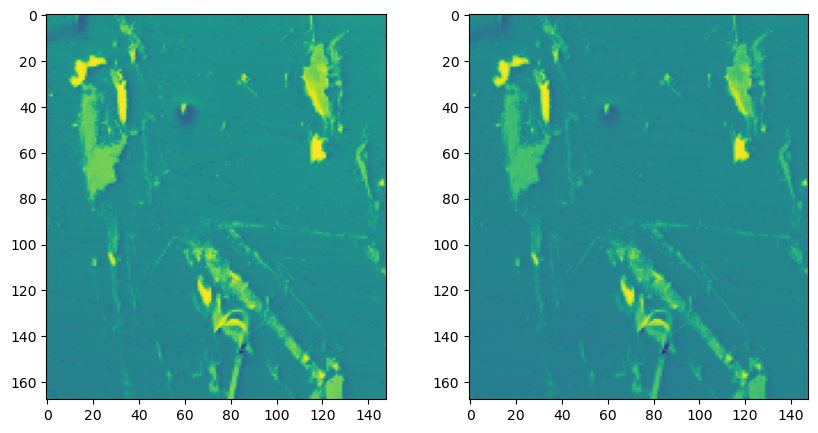

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(reduced_maps[:,:,0])
ax[1].imshow(reduced_maps[:,:,1])

# GPcam

## define parameters

In [ ]:
def ndim_aqfunc(x, gp):
    """Compute the acquisition function for a given GP and a given point"""
    a = 1.5  #####change here, 3.0 for 95 percent confidence interval
    norm = 1.0
    ret = None
    for i in range(gp.input_dim-1):
        x_pred=np.c_[x,np.zeros(x.shape[0])+i].reshape(-1,gp.input_dim)
        cov = gp.posterior_covariance(x_pred)["v(x)"]
        if ret is None:
            ret = cov
        else:
            ret += cov
            
    ret=a * np.sqrt(ret)

    for i in range(gp.input_dim-1):
        x_pred=np.c_[x,np.zeros(x.shape[0])+i].reshape(-1,gp.input_dim)
        mean = gp.posterior_mean(x_pred)["f(x)"]
        ret += norm * mean

    return ret


In [ ]:
def manhattan_distance(x,y):
    return np.abs(x[0]-y[0])+np.abs(x[1]-y[1])

def movement_cost(
        origin: tuple, 
        x: tuple, 
        cost_func_params: dict = None, 
        verbose: bool = False
    ) -> float:
    """Compute the cost of moving from x to y
    
    Args:
        x (tuple): starting position
        y (tuple): ending position
        cost_func_params (dict): dictionary of parameters for the cost function
            - speed (float): speed of the scanner, expressed in mm/s
            - dwell_time (float): dwell time, expressed in s
            - dead_time (float): dead time, expressed in s
            - point_to_um (float): conversion factor from mm to seconds
    
    Returns:
        float: cost of moving from x to y, expressed in seconds

    """
    x = np.array(x)
    if len(x.shape) == 1:
        x = x.reshape(-1,1)
    if cost_func_params is None:
        cost_func_params = {}
    else:
        cost_func_params = cost_func_params.copy()
    speed = cost_func_params.pop('speed',250)
    dwell_time = cost_func_params.pop('dwell_time',0.5)
    dead_time = cost_func_params.pop('dead_time',0.6)
    point_to_um = cost_func_params.pop('point_to_um',1.0)
    weight = cost_func_params.pop('weight',1.0)
    min_distance = cost_func_params.pop('min_distance',1.0)

    gp_x_data:np.ndarray = cost_func_params.pop('prev_points',np.empty((0,2)))
    prev_points = gp_x_data[:,:2]
    # all_distances = np.array([manhattan_distance(x,p) for p in prev_points])
    all_distances = np.array([np.linalg.norm(x-p) for p in prev_points])
    if np.any(all_distances < min_distance):
        idx = np.argmin(all_distances - min_distance)
        if verbose:
            print(f"Point {np.asarray(x).ravel()} close to previous point {prev_points[idx]}: d={all_distances[idx]}")
        return [1_000_000]
    # if any([manhattan_distance(x,p) < min_distance for p in prev_points]):
    #     print(f"Point {x} close to previous points")
    #     if verbose:
    #         print(f"Point already visited, returning {1_000_000}")
    #     return [1_000_000]

    if len(cost_func_params) > 0:
        raise ValueError(f"Unrecognized parameters: {cost_func_params.keys()}")
    distance = manhattan_distance(origin,x) * point_to_um
    time = weight * distance / speed  + dwell_time + dead_time
    if verbose:
        print(f"Distance: {distance:.2f} um, Time: {time:.2f} s"
            f" (dwell: {dwell_time:.2f} s, dead: {dead_time:.2f} s)" 
        )
    return time

def cost_function(origin, x:Sequence[tuple], cost_func_params: dict = None, verbose=False) -> float:
    cost = []
    for xx in x:
        movcost = movement_cost(origin,xx,cost_func_params,verbose=verbose)
        cost.append(movcost)
    return np.asarray(cost).T

cost_function((0,0),[(0,0),(1,1),(2,2)], cost_func_params={'prev_points':np.array([(1,1)])},verbose=False)

array([[1.100e+00, 1.000e+06, 1.116e+00]])

In [ ]:
def closest_point_on_grid(x):
    """Find the closest point in a grid to a given point"""
    grid = np.array(tuple(product(range(xdata.shape[0]),range(xdata.shape[1]))))
    return grid[np.linalg.norm(grid-x,axis=1).argmin()]

def scan_time(positions, cost_func_params):
    return np.sum([movement_cost(positions[i-1],positions[i],cost_func_params) for i in range(1,len(positions))])

def how_many_repeated_points(positions):
    counts = list(dict(Counter(tuple(map(tuple,positions)))).values())
    return sum(counts)-len(counts)

def duplicate_positions(positions):
    """ a dict with the number of repetitions of each position when the repetition is > 1"""
    counts = dict(Counter(tuple(map(tuple,positions))))
    return {k:v for k,v in counts.items() if v > 1}


In [ ]:

def measurement_loop(
    init_positions, 
    init_values,
    gp,
    n_points=200,
    train_every=20,
    train_at = None,
    verbose=False,
) -> None:
        
    values = init_values.copy()
    positions = init_positions.copy()
    for i in tqdm(range(n_points), desc="Acquisition loop"):
        gp.tell(positions, values)
        next_pt = gp.ask(position=positions[-1],**ask_pars)
        next_on_grid = closest_point_on_grid(next_pt['x'])
        next_pt.update({'pos':next_on_grid})
        next_val = np.array(
            reduce(xdata[next_pt['pos'][0],next_pt['pos'][1]].values)
        )[None,:]
        next_pos = np.array(next_pt['pos'])[None,:]
        # print(next_val,next_pos, sep='\n')
        positions = np.append(positions, next_pos, axis=0)
        values = np.append(values, next_val, axis=0)
        if train_at is None:
            train_at = []
        if i % train_every == 0 or i in train_at:
            t0 = time.time()
            gp.train_gp(**train_pars)
            print(f"Training at i={i} took {time.time()-t0:.2f} s")
    return positions, values
            



In [ ]:

def vis_map_with_path(positions,values,reduced_maps=reduced_maps,ax=None):
    if ax is None:
        fig,ax = plt.subplots(1,1,figsize=(6,5))
    ax.imshow(reduced_maps[...,0],alpha=0.5)
    # ax[1].imshow(reduced_maps[...,0],alpha=0.5)
    ax.plot(positions[:,1],positions[:,0],'r-',alpha=0.5,linewidth=.5)
    ax.scatter(positions[:,1],positions[:,0],s=10)#,c=values[:,0],cmap='viridis')
    # ax[1].scatter(positions[:,1],positions[:,0],s=10)#c=values[:,0],cmap='viridis')

def plot_map_with_path_and_scatterplot(positions,values,reduced_maps):
    fig,ax = plt.subplots(1,2,figsize=(12,5))
    ax[0].imshow(reduced_maps[...,0],alpha=0.5,origin='lower')
    ax[1].imshow(reduced_maps[...,0],alpha=0.0,origin='lower')
    ax[0].plot(positions[:,1],positions[:,0],'r-',alpha=0.5,linewidth=.5)
    ax[0].scatter(positions[:,1],positions[:,0],s=10,c='b')
    ax[1].scatter(positions[:,1],positions[:,0],s=25,c=-values[:,0],cmap='viridis',marker='s')

In [ ]:
optimizer_pars = {
    'input_space_dimension': 2,
    'output_space_dimension': 1,
    'output_number': 2,
    'input_space_bounds': scan_limits,
}
hyperparameter_bounds = np.array(
    [[0.001,1e9],[1,1000],[1,1000],[1,1000],[1,1000]]
)
init_hyperparameters = np.array(
        [4.71907062e+06, 4.07439017e+02, 3.59068120e+02,4e2,4e2]
)
train_pars = {
    'hyperparameter_bounds': hyperparameter_bounds,
    'pop_size': 20,
    'tolerance': 1e-6,
    'max_iter': 2,
}
train_async_pars = {
    'hyperparameter_bounds':hyperparameter_bounds,
    'init_hyperparameters': init_hyperparameters,
    'max_iter': 10000,
    'local_optimizer': "L-BFGS-B",
    'global_optimizer': "genetic",
    'constraints': (),
    'deflation_radius': None,
    'dask_client': None,
}
train_gp_async_pars = {
    'hyperparameter_bounds':hyperparameter_bounds,
    'max_iter': 10000,
    'dask_client': None,
    'deflation_radius': None,
    'constraints': (),
    'local_method': "L-BFGS-B",
    'global_method': "genetic",
}
fvgp_pars = {
    'init_hyperparameters' : init_hyperparameters,
    'compute_device': 'cpu',
    'gp_kernel_function': None,
    'gp_mean_function': None,
    'use_inv':False,
    'ram_economy': True,
}
ask_pars = {
    'n': 1, 
    'acquisition_function': ndim_aqfunc, 
    'bounds': None,
    'method': 'global', 
    'pop_size': 20, 
    'max_iter': 10, 
    'tol': 10e-6, 
    'x0': None, 
    'dask_client': None,
}
cost_func_params = {
    'speed':300,
    'dwell_time':1.0,
    'dead_time':0.6,
    'point_to_um':15,
    'weight':1.0,
    'min_distance':1.6
}

# Single point initializationm

In [ ]:
init_positions = np.array([
    [map_shape[0]//2,map_shape[1]//2],
    # [map_shape[0]//2,map_shape[1]//2],
])
init_values = np.array([
    np.array(reduce(xdata[init_positions[:,0],init_positions[:,1]].values)),
    # np.array(reduce(xdata[init_positions[0],init_positions[1]].values)),
])
init_positions, init_values


(array([[84, 74]]), array([[0.8064644, 0.6098814]]))

In [ ]:
gp = fvGPOptimizer(**optimizer_pars)
gp.tell(init_positions,init_values)
gp.init_fvgp(**fvgp_pars)
gp.train_gp(**train_pars)
positions = init_positions.copy()
values = init_values.copy()
cost_func_params.update({
    'prev_points':gp.x_data,
    'weight':0.02,
    'min_distance':.6,
})
gp.init_cost(cost_function,cost_func_params)
positions.shape, values.shape


((1, 2), (1, 2))

In [ ]:
# init_positions, init_values = pos, vals

In [ ]:
pos, vals = measurement_loop(
    init_positions, 
    init_values, 
    gp,
    n_points=1000, 
    train_every=100000,
    train_at = [10, 20, 40, 80, 160, 320, 640, 1280, 2560, 5120],
    verbose=True,
)

Acquisition loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Training at i=0 took 0.09 s
Training at i=10 took 0.12 s
Training at i=20 took 0.17 s
Training at i=40 took 0.24 s
Training at i=80 took 0.46 s
Training at i=160 took 1.20 s
Training at i=320 took 11.51 s
Training at i=640 took 49.77 s


weight = .2
Number of repeated points: 91
no cost scan time:   00:27:19
raster scan time:    11:03:50


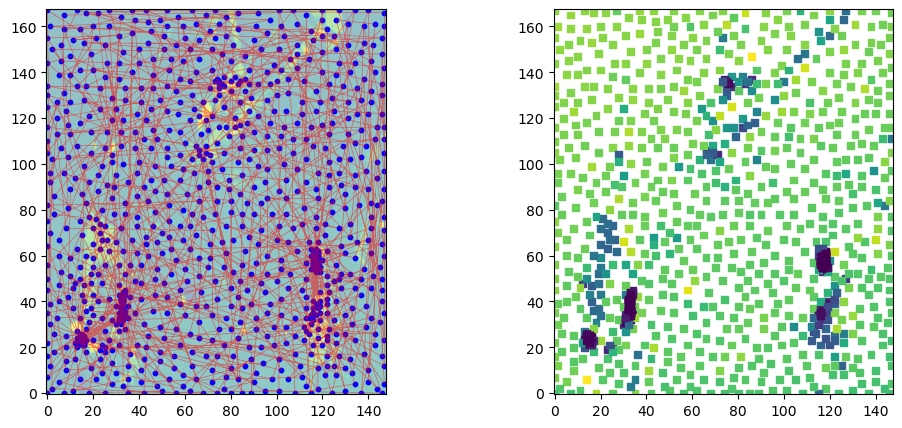

In [39]:
print('weight = .2')
print(f'Number of repeated points: {how_many_repeated_points(pos)}')
print(f'no cost scan time:   ' +pretty_print_time(scan_time(pos,cost_func_params)))
print(f'raster scan time:    ' +pretty_print_time(scan_time(all_positions,cost_func_params)))
# print(f'repeated points: {duplicate_positions(pos)}')
plot_map_with_path_and_scatterplot(pos,vals,reduced_maps=reduced_maps)
# print(f'scan time: {scan_time(pos_wcost,cost_func_params):.2f} s')

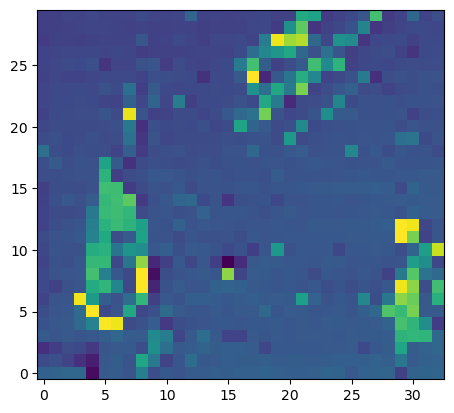

In [54]:
plt.figure()
plt.imshow(reduced_maps[:150:5,:132:4,0],origin='lower')

In [46]:
reduced_maps.shape

(168, 148, 2)

In [45]:
reduced_maps.shape[0]//30
reduced_maps.shape[1]//30


1258

In [51]:

np.prod(reduced_maps[:150:5,:132:4,0].shape)

990

In [37]:
# weight .2

In [35]:
print(f'Number of repeated points: {how_many_repeated_points(pos)}')
print(f'repeated points: {duplicate_positions(pos)}')
# print(f'scan time: {scan_time(pos_wcost,cost_func_params):.2f} s')

Number of repeated points: 91
repeated points: {(40, 33): 4, (60, 118): 3, (55, 119): 2, (55, 117): 6, (58, 117): 3, (33, 32): 2, (22, 14): 2, (42, 32): 2, (61, 117): 4, (56, 118): 5, (34, 32): 4, (36, 32): 4, (23, 15): 4, (24, 14): 3, (41, 32): 4, (24, 15): 4, (24, 16): 2, (35, 33): 5, (34, 33): 2, (58, 116): 2, (59, 117): 3, (56, 117): 3, (60, 117): 3, (57, 117): 6, (62, 118): 2, (57, 118): 2, (55, 116): 2, (62, 117): 2, (57, 116): 3, (58, 118): 2, (36, 33): 6, (42, 33): 2, (32, 31): 2, (25, 15): 3, (35, 116): 3, (56, 116): 2, (34, 115): 2, (61, 118): 3, (41, 33): 2, (43, 33): 2, (40, 32): 3, (37, 32): 2, (22, 16): 2, (21, 16): 2, (22, 15): 4, (25, 14): 2}


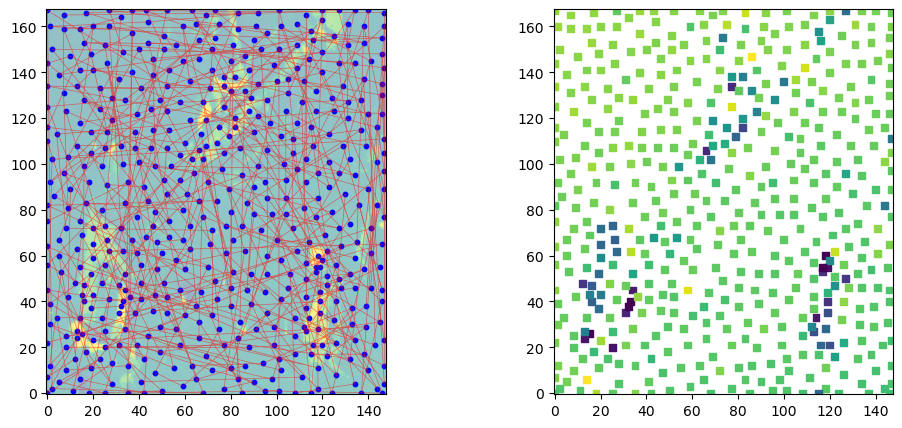

In [36]:
n = 500
p,v = pos[:n], vals[:n]
# how_many_repetitions(p)
# vis_map_with_path(p,v,reduced_maps=reduced_maps)
plot_map_with_path_and_scatterplot(p,v,reduced_maps=reduced_maps)

In [29]:
print(f'no cost scan time:   ' +pretty_print_time(scan_time(pos,cost_func_params)))
print(f'raster scan time:    ' +pretty_print_time(scan_time(all_positions,cost_func_params)))

no cost scan time:   00:27:58
raster scan time:    11:05:04


In [ ]:
# count repeated points
from collections import Counter
counts = list(dict(Counter(tuple(map(tuple,pos_wcost)))).values())

print(f'Number of repeated points: {sum(counts)-len(counts)}')


In [ ]:
fig,axes = plt.subplots(1,2,figsize=(10,5))

vis_map_with_path(pos_wcost, values_wcost,reduced_maps=reduced_maps,ax=axes[0])
vis_map_with_path(pos_nocost, values_nocost,reduced_maps=reduced_maps,ax=axes[1])

# now for something silly!

In [ ]:
gp = fvGPOptimizer(**optimizer_pars)
gp.tell(init_positions,init_values)
gp.init_fvgp(**fvgp_pars)
gp.train_gp(**train_pars)
positions = init_positions.copy()
values = init_values.copy()
positions.shape, values.shape
cfp = cost_func_params.copy()
cfp['weight'] = 0.1
gp.init_cost(cost_function,cost_func_params)

In [ ]:

pos_highcost, values_highcost = measurement_loop(
    init_positions, 
    init_values, 
    n_points=500, 
    train_every=50,
    train_at = [10, 20],
    verbose=True,
)
counts = list(dict(Counter(tuple(map(tuple,pos_highcost)))).values())
print(f'Number of repeated points: {sum(counts)-len(counts)}')

In [ ]:
vis_map_with_path(pos_highcost, values_highcost,reduced_maps=reduced_maps)

In [ ]:
plt.figure()
n = 500
plt.scatter(pos_highcost[:n,1],pos_highcost[:n,0],c=values_highcost[:n,0],cmap='viridis')

In [ ]:
print(f'scan time: {scan_time(pos_highcost,cost_func_params):.2f} s')

In [ ]:
print(f'no cost scan time:   ' +pretty_print_time(scan_time(pos_nocost,cost_func_params)))
print(f'low cost scan time:  ' +pretty_print_time(scan_time(pos_wcost,cost_func_params)))
print(f'high cost scan time: ' +pretty_print_time(scan_time(pos_highcost,cost_func_params)))
print(f'raster scan time:    ' +pretty_print_time(scan_time(all_positions,cost_func_params)))


In [ ]:
all_positions

In [ ]:
def get_raw_data(positions,all_positions,xdata):
    raw = []
    for n in range(len(all_positions)):
        if all_positions[n] in positions:
            i,j = all_positions[n]
            raw.append(xdata[i,j,...].values)
    return raw

    

In [ ]:
raw_nocost = get_raw_data(pos_nocost,all_positions,xdata)

In [ ]:
raw_nocost[0].shape


# kmeans on this thing

In [ ]:
import sklearn.cluster as cluster  


In [ ]:
res = cluster.kmeans(raw_nocost,n_clusters=3)